In [1]:
import json
import os
import typing
from collections import defaultdict, namedtuple
from functools import partial
from pathlib import Path
from typing import Type
import matplotlib.pyplot as plt

import einops
import numpy as np
import pandas as pd
import torch as t
from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce, plot_trace
from devinterp.vis_utils import EpsilonBetaAnalyzer
from jaxtyping import Float
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

import wandb
from pizza_clock.config import Config, get_device
from pizza_clock.dataset import AdditionDataset, get_train_val_data
from pizza_clock.metrics import compute_gradient_symmetry
from pizza_clock.training import ModularAdditionModelTrainer
from pizza_clock.llc_estimation_utils import *


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

100 100 100


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

100 100 100


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

100 100 100


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

100 100 100
CPU times: user 5h 9min 39s, sys: 1h 3min 1s, total: 6h 12min 41s
Wall time: 7h 24min 18s


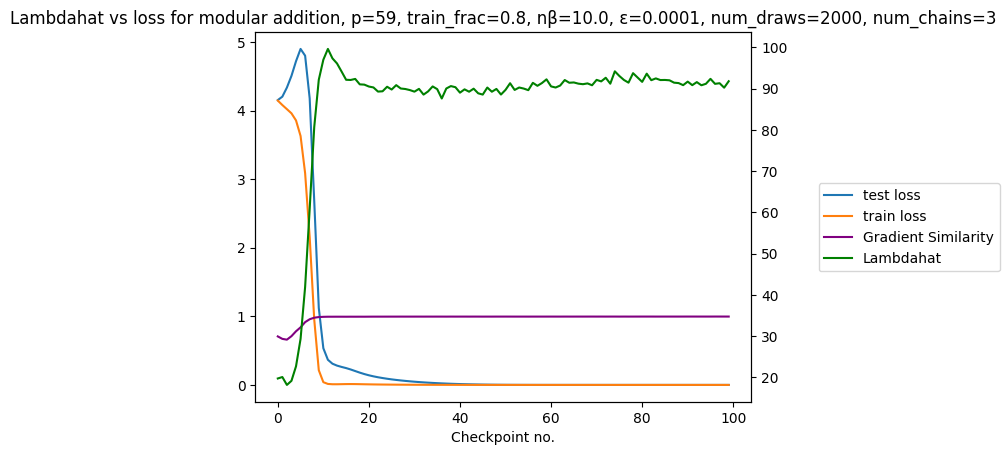

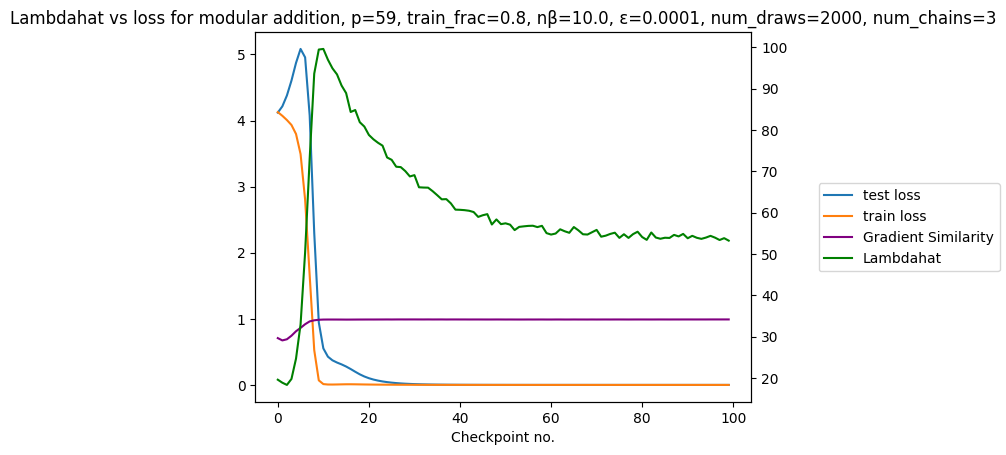

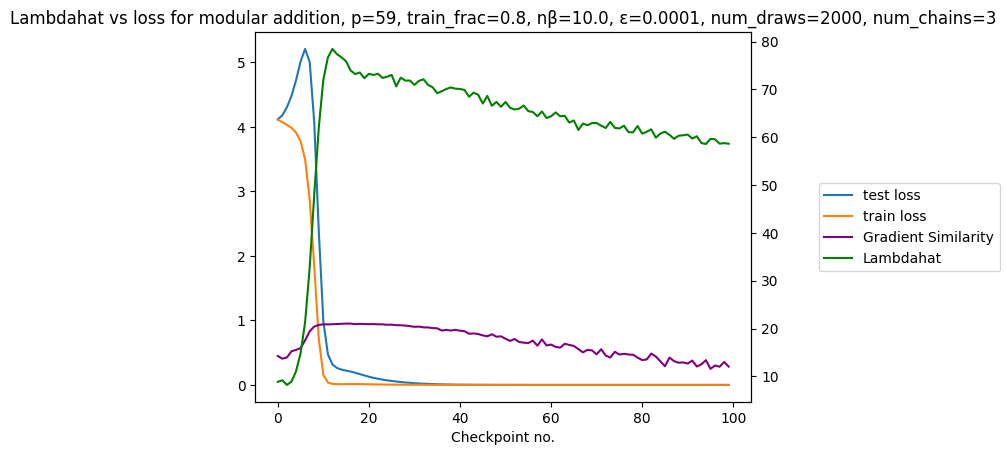

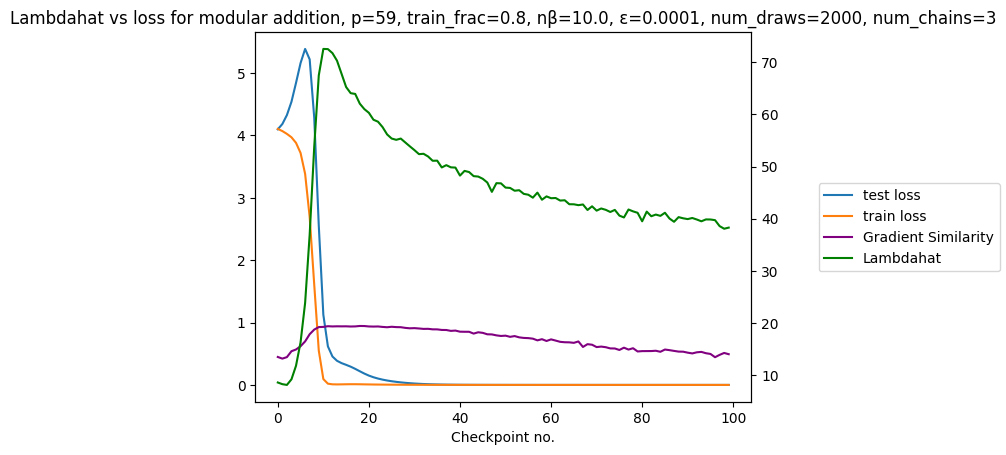

In [2]:
%%time
for attn in [0.0, 1.0]:
    for seed in range(6,8):
        llc = estimate_and_plot_llc_for_all_models(
            dir_path=f"saved_models/2026-02-11/attn{attn}_seed{seed}",
            localization=100,
            lr=1e-4,
            num_draws=2000,
        )

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn0.0_seed0


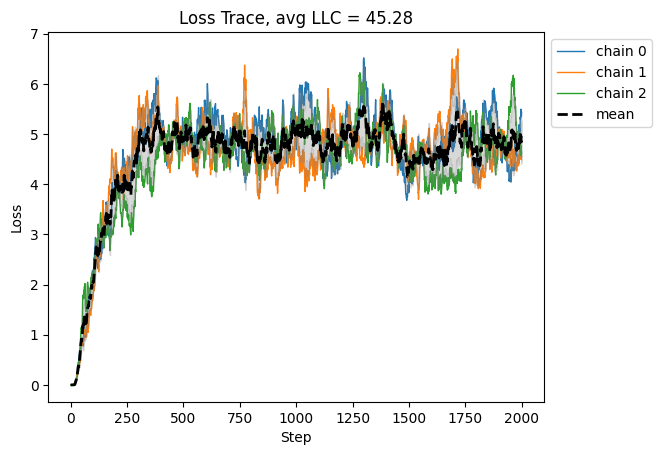

<Figure size 1200x900 with 0 Axes>

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn0.0_seed1


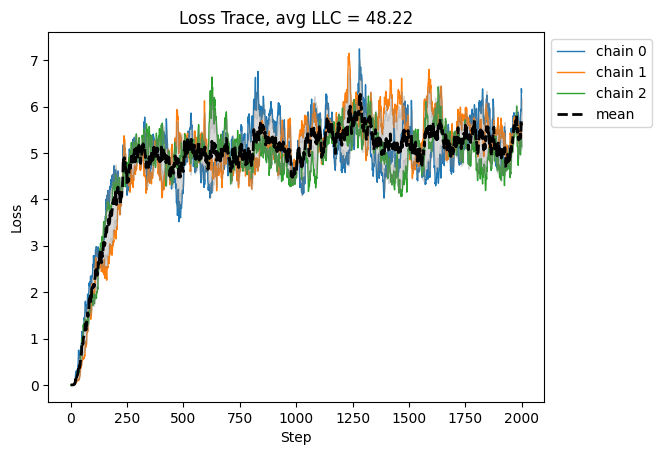

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 91.62it/s]


saved_models/2026-01-27/attn0.0_seed2


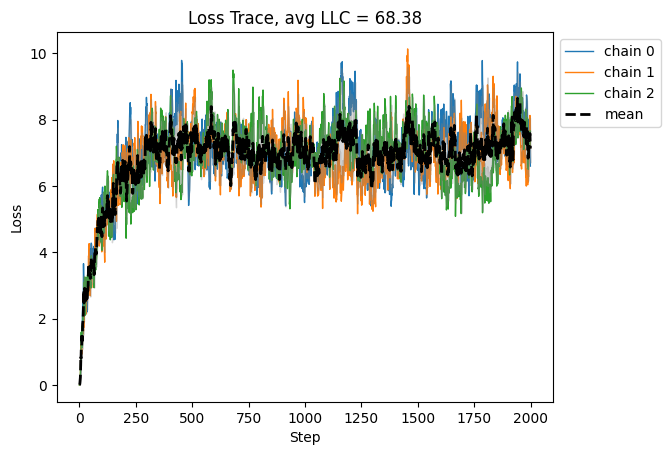

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 92.12it/s]


saved_models/2026-01-27/attn0.0_seed3


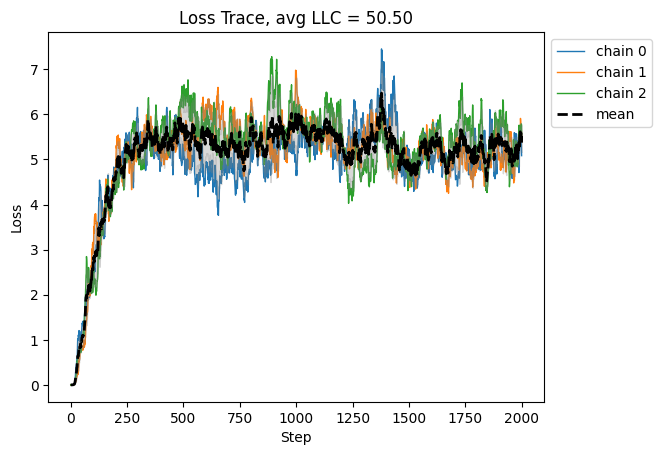

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 92.08it/s]

saved_models/2026-01-27/attn0.0_seed4


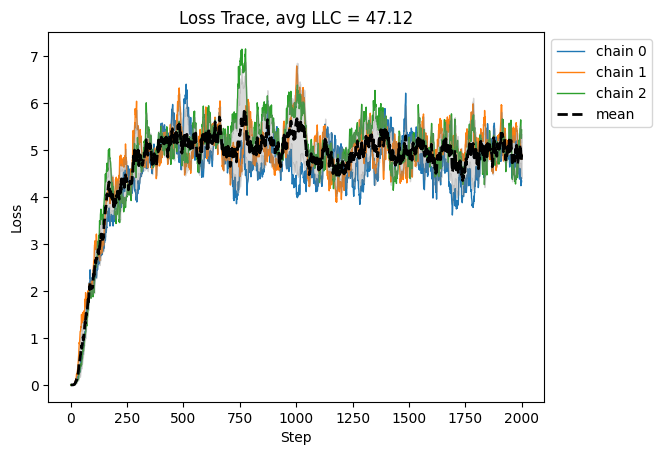

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 91.72it/s]


saved_models/2026-01-27/attn1.0_seed0


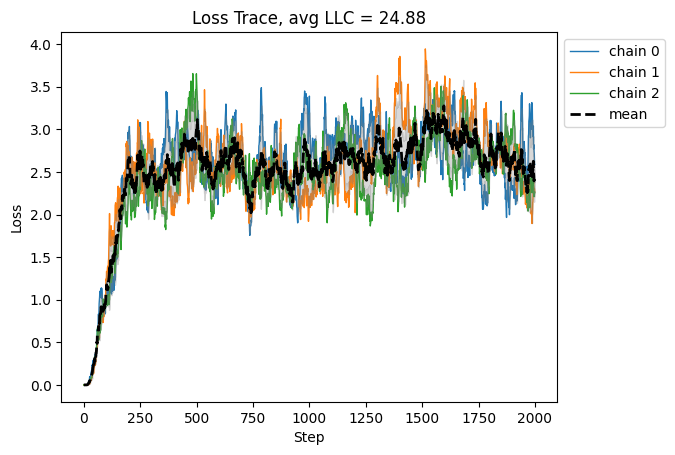

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 91.52it/s]


saved_models/2026-01-27/attn1.0_seed1


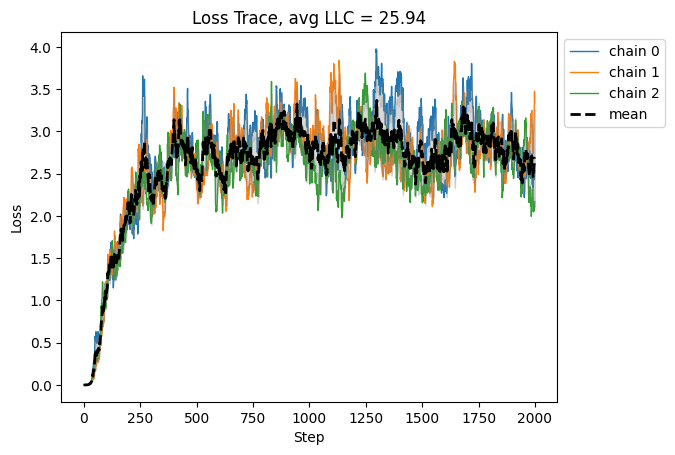

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 91.93it/s]


saved_models/2026-01-27/attn1.0_seed2


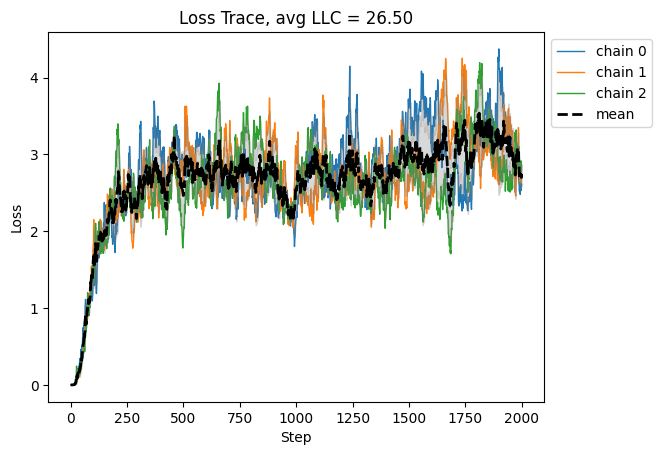

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:22<00:00, 90.75it/s]

saved_models/2026-01-27/attn1.0_seed3


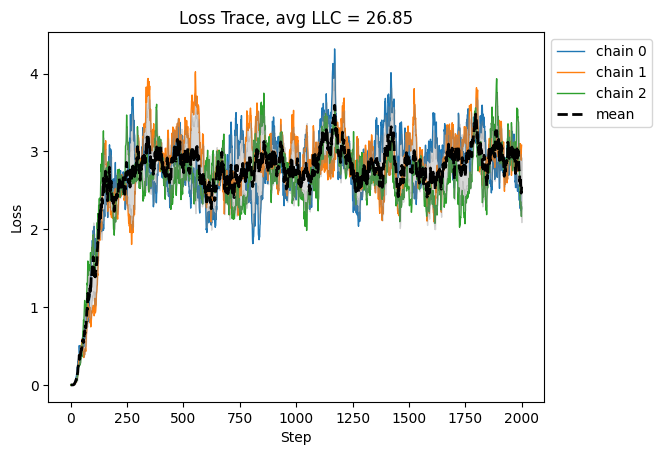

<Figure size 1200x900 with 0 Axes>

Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 93.19it/s]

saved_models/2026-01-27/attn1.0_seed4


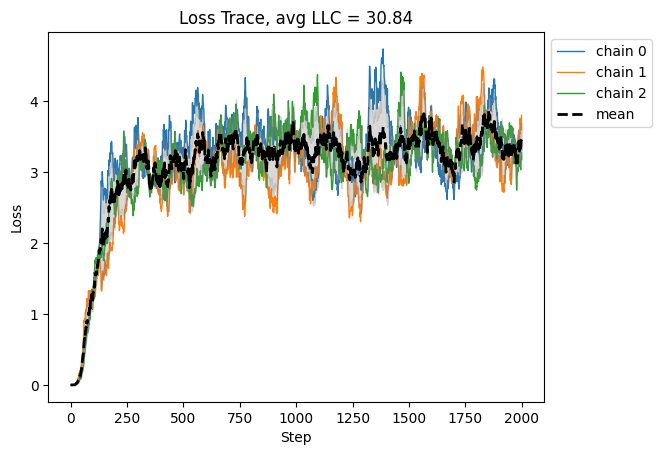

<Figure size 1200x900 with 0 Axes>

In [ ]:
attn_to_llc = {}
for attn in [0.0, 1.0]:
    attn_to_llc[attn] = []
    for seed in range(5):
        llc = estimate_and_plot_llc_for_final_model(
            dir_path=f"saved_models/2026-01-27/attn{attn}_seed{seed}",
            localization=100,
            lr=1e-4,
            num_draws=2000,
        )
        attn_to_llc[attn].append(llc)


In [4]:
attn_to_llc

{0.0: [np.float32(45.284325),
  np.float32(48.215866),
  np.float32(68.383354),
  np.float32(50.495735),
  np.float32(47.120453)],
 1.0: [np.float32(24.879566),
  np.float32(25.93705),
  np.float32(26.495615),
  np.float32(26.84756),
  np.float32(30.841604)]}

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

200 200 20


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 91.50it/s]
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in ste

200 200 20


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
Chain 2: 100%|██████████| 2000/2000 [00:25<00:00, 78.87it/s]


200 200 20


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

200 200 20


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 93.54it/s]
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in ste

200 200 20


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 93.46it/s]
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in ste

200 200 20


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
Chain 2: 100%|██████████| 2000/2000 [00:22<00:00, 90.23it/s]
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in ste

200 200 20


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 94.16it/s]
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in ste

200 200 20


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 92.44it/s]
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in ste

200 200 20


/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
Chain 2: 100%|██████████| 2000/2000 [00:21<00:00, 93.06it/s]


200 200 20


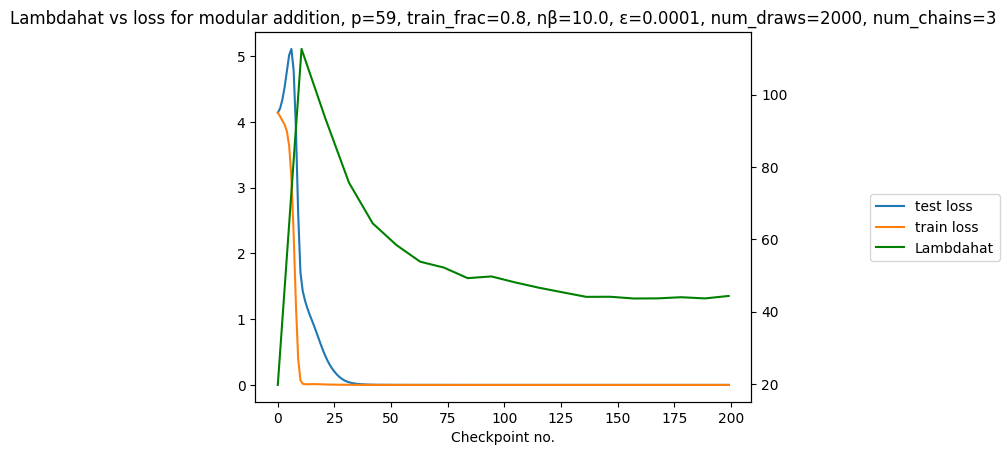

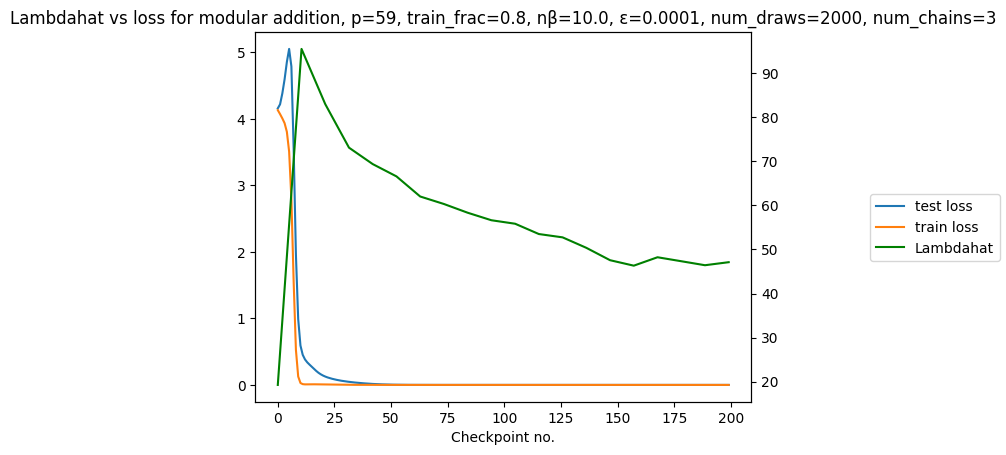

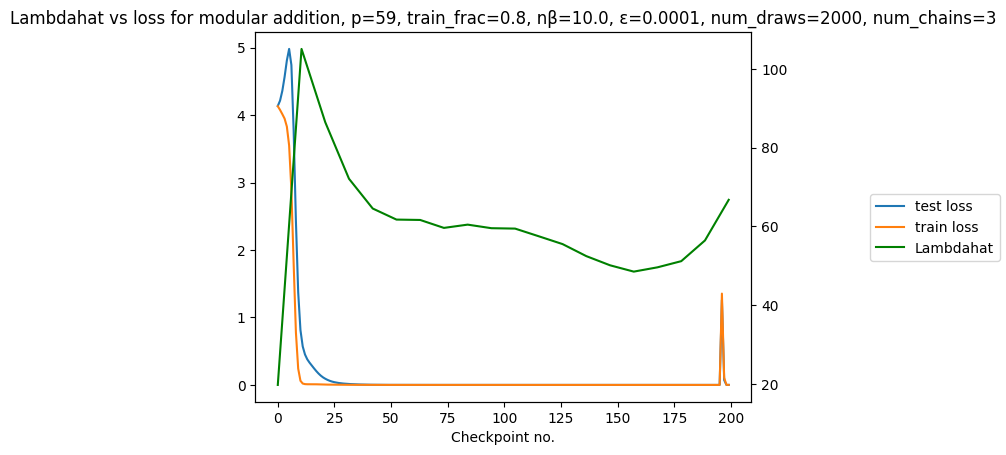

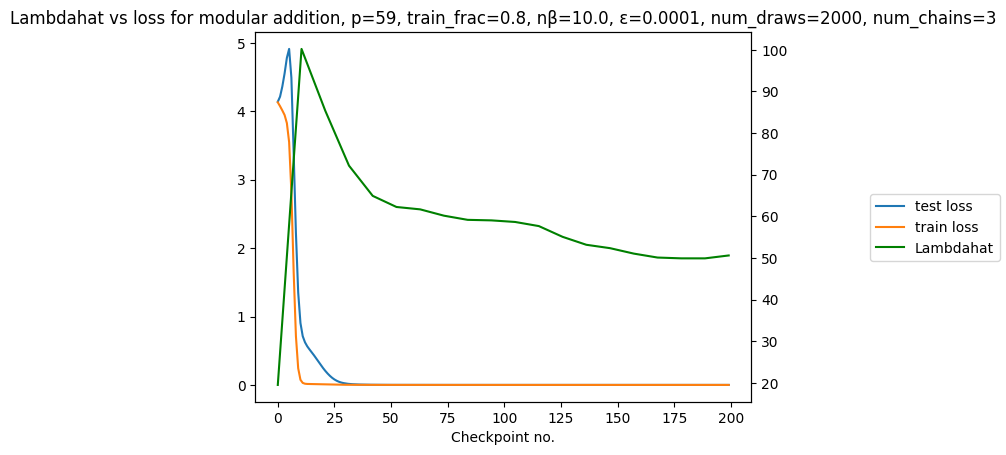

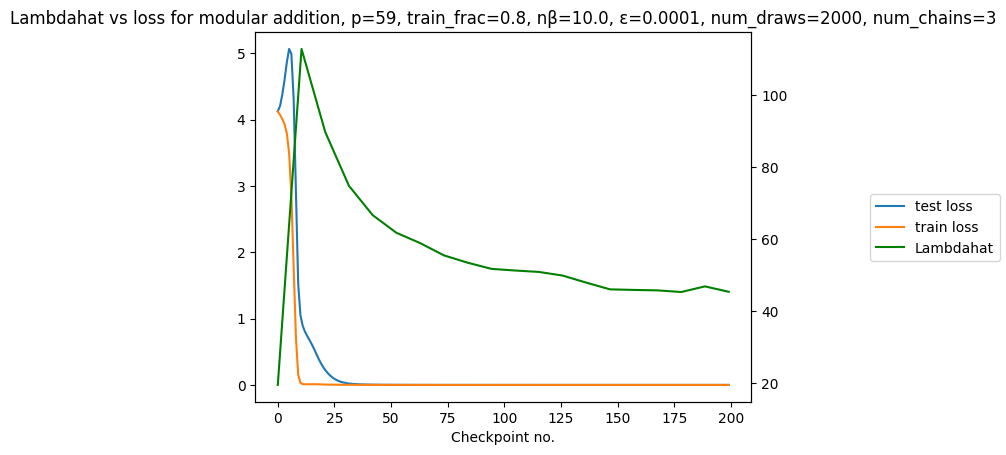

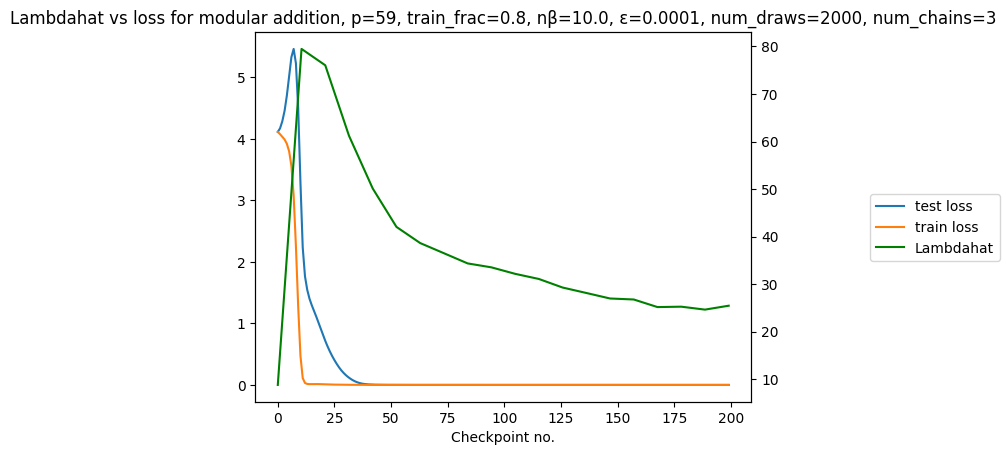

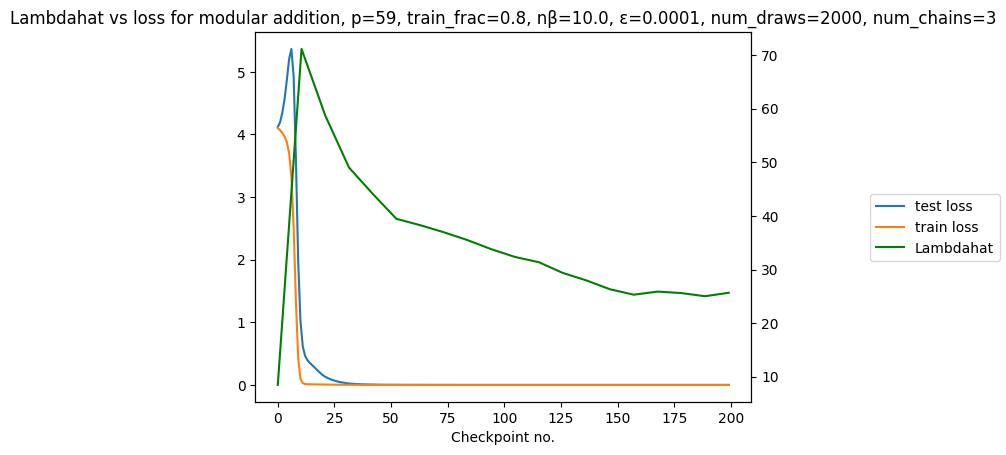

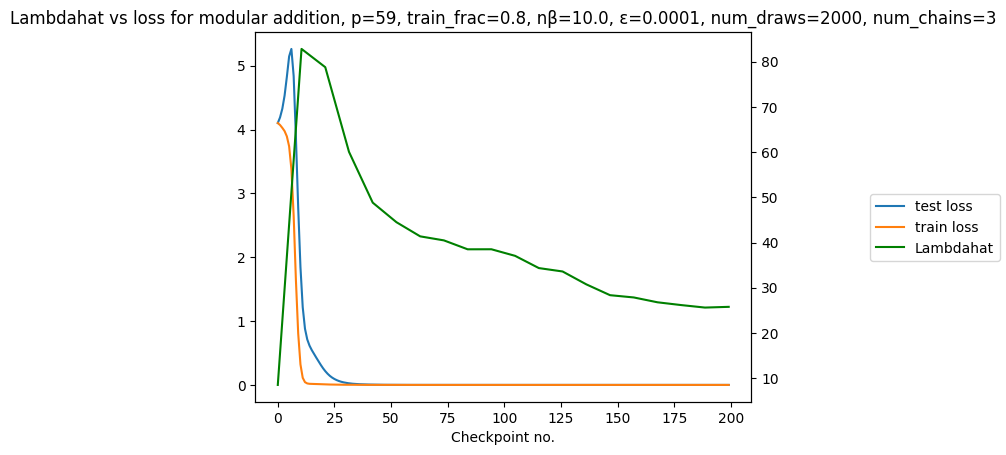

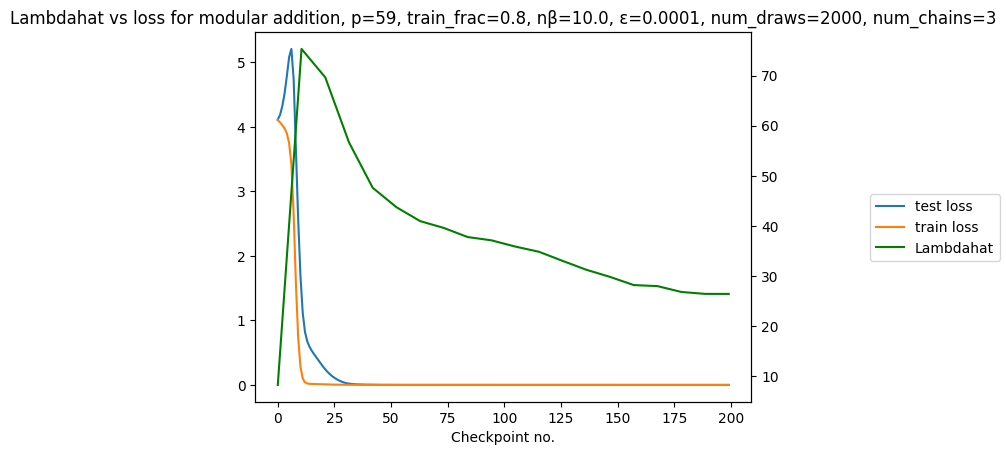

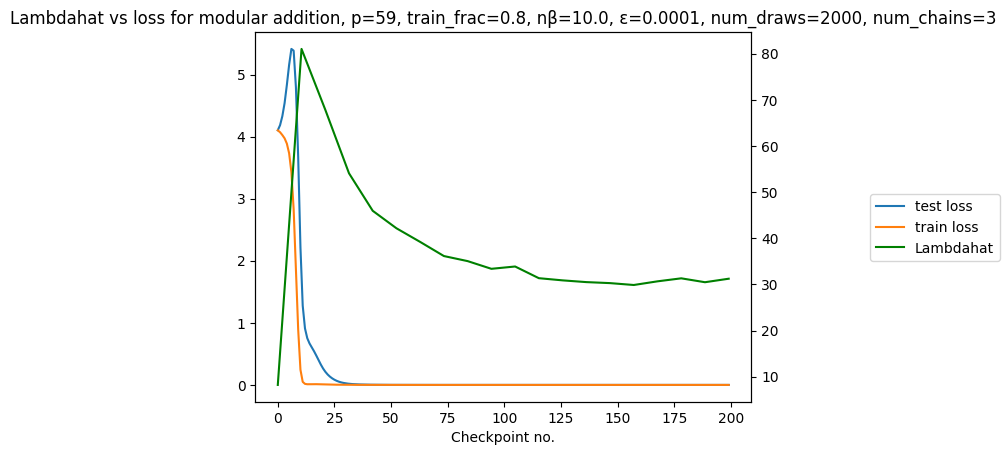

In [5]:
for attn in [0.0, 1.0]:
    for seed in range(5):
        llc = estimate_and_plot_llc_for_all_models(
            dir_path=f"saved_models/2026-01-27/attn{attn}_seed{seed}",
            localization=100,
            lr=1e-4,
            num_draws=2000,
        )

Some bad parameter settings

In [ ]:
sweep("saved_models/2026-01-27/attn0.0_seed4")

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn0.0_seed4


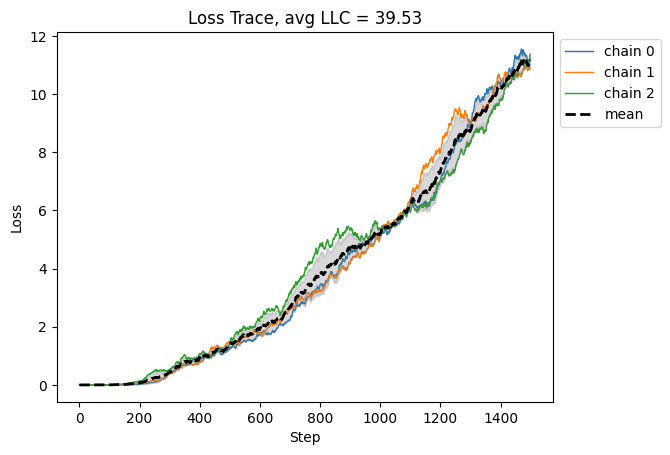

<Figure size 1200x900 with 0 Axes>

In [ ]:
estimate_and_plot_llc_for_final_model("saved_models/2026-01-27/attn0.0_seed4")

Chain 2: 100%|██████████| 1500/1500 [00:16<00:00, 91.35it/s]


saved_models/2026-01-27/attn1.0_seed3


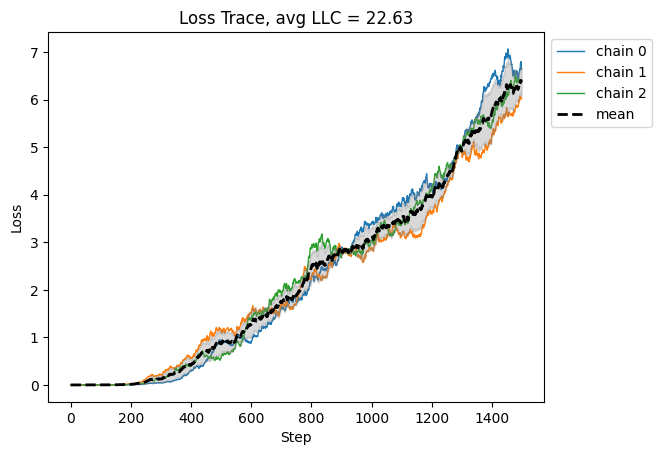

<Figure size 1200x900 with 0 Axes>

In [ ]:
estimate_and_plot_llc_for_final_model(dir_path="saved_models/2026-01-27/attn1.0_seed3")

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn1.0_seed0


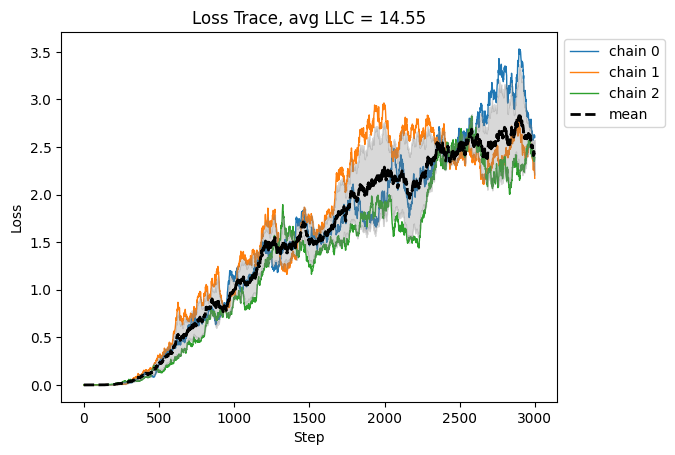

<Figure size 1200x900 with 0 Axes>

In [ ]:
estimate_and_plot_llc_for_final_model(
    dir_path="saved_models/2026-01-27/attn1.0_seed0",
    localization=100,
    lr=1e-5,
    num_draws=3000,
)

/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/hanna/Library/Caches/pypoetry/virtualenvs/pizza-clock--vnaSbzg-py3.13/lib/python3.13/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be 

saved_models/2026-01-27/attn1.0_seed0


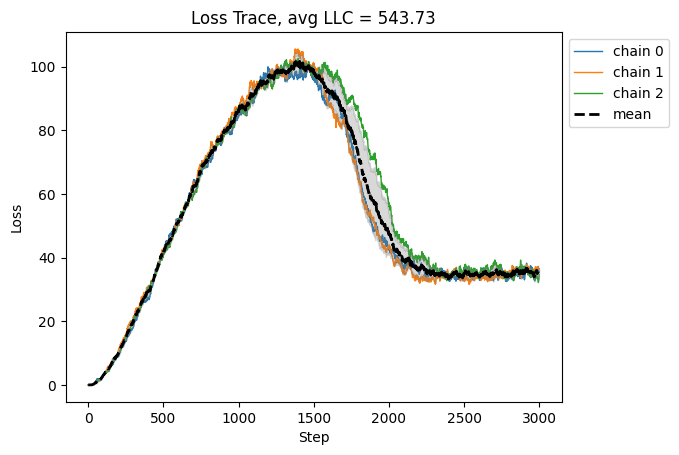

<Figure size 1200x900 with 0 Axes>

In [ ]:
estimate_and_plot_llc_for_final_model(
    dir_path="saved_models/2026-01-27/attn1.0_seed0",
    localization=10,
    lr=1e-4,
    num_draws=3000,
)